In [1]:
# importing module
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
from myutils import *
from SLBQP import SLBQP
from datastorer import DataStorer
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import time
plt.style.use('seaborn')
params = {
    'figure.figsize': (20, 10),
    'legend.fontsize': 'x-large',
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large',
    'axes.titlesize': 'x-large',
}
plt.rcParams.update(params)

# Utility Functions

In [2]:
def load_runs(folder, size, algorithm, nproblems, measurement="val"):
    """
    TODO: COMMENT
    """
    if not folder.endswith("/"):
        folder += "/"
    algoritm = "ROS" if algorithm.lower().startswith("r") else "GOLD"
    path = f"{folder}{size}/{algorithm}"
    val_list = []
    for i in range(nproblems):
        filepath = f"{path}/{i}.csv"
        val = pd.read_csv(filepath, usecols=[measurement]).to_numpy()
        val_list.append(val)
    return np.array(val_list)

def load_external_solver_values(folder, size, filename="optimal_values.txt"):
    """
    TODO: COMMENT
    """
    if not folder.endswith("/"):
        folder += "/"
    path = f"{folder}{size}/{filename}"
    
    with open(path, "r") as f:
        opt_vals = f.readlines()
        opt_vals = [np.float64(x.strip()) for x in opt_vals]
        return np.array(opt_vals)

def load_alpha_runs(folder, nproblems):
    """
    
    """
    if not folder.endswith("/"):
        folder += "/"
    
    alpha_values = []
    for i in range(nproblems):
        path = f"{folder}{i}.csv"
        av = pd.read_csv(path, usecols=["val"]).to_numpy()
        alpha_values.append(av)
    return np.array(alpha_values)

def load_external_solver_alphas(folder, filename="optimal_values.txt"):
    """
    TODO: COMMENT
    """
    if not folder.endswith("/"):
        folder += "/"
    
    path = f"{folder}{filename}"
    with open(path, "r") as f:
        opt_vals = f.readlines()
        opt_vals = [np.float64(x.strip()) for x in opt_vals]
        return np.array(opt_vals)

In [7]:
def relative_gap(val, opt):
    """
    TODO: COMMENT
    """
    diff = val - opt
    assert(all(diff > 0))
    return (val - opt) / np.abs(opt)

In [35]:
def convergence_rate(values, optimal_values):
    """
    TODO: COMMENT
    """
    tmp = values - optimal_values
    res = []
    for l in tmp:
        res.append(l[1:] / l[:-1])
    return np.array(res)

# PATHS

In [5]:
rootfolders = "C1EPS_001,C1EPS_01,C_01EPS01,C_05EPS01,C_1EPS01,C_2EPS01,C1EPS_1,C_5EPS01,C_10EPS01".split(",")
rootdataset = "AIRF CAL ML".split(" ")
problem_sizes = [100, 200,300,400,500, 600]
epsilons = [x for x in rootfolders if "EPS_" in x]
upperbounds = [x for x in rootfolders if "C_" in x]

# ML - UPPERBOUNDS

In [ ]:
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(20,10))
sizes = problem_sizes #[300,600]
chosen_uppers = upperbounds
for i,root in enumerate(chosen_uppers):
    for j,size in enumerate(sizes):
        ax = axs[j][i]        
        values_rosen = load_problems(str(size), alg="rosen", maindir=f"RUNS/ML/{root}", nproblems=20)
        values_goldstein =  load_problems(str(size), alg="goldstein", maindir=f"RUNS/ML/{root}", nproblems=20)
        
        best_values = get_best_values(dataset="ML", size=size, params=root)
        
        values_rosen = [transform_values(i, opt) for i, opt in zip(values_rosen, best_values)]
        values_goldstein = [transform_values(i, opt) for i, opt in zip(values_goldstein, best_values)]
        
        
        
        plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
        plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
        #ax.set_title(str(size), fontdict={'fontsize': 15})
        #ax.set_yscale("symlog")
        #ax.set_xscale("log") # use logaritmic scale for x
        ax.set_yscale("log")
        m, M = ax.get_ylim()
        #ax.vlines(30, m-10, M+10,colors='r', linestyles='dashed')

for ax, size in zip(axs[:,0], sizes):
    ax.set_ylabel(str(size))
    

for ax, c in zip(axs[0], [0.1, 1, 5, 10]):
    ax.set_title(f"$C = {c}$")

for ax in axs[1]:
    ax.set_xlabel("iterations")



plt.tight_layout()

# AIRFOIL - Upperbounds

In [ ]:
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(30,20))
sizes = problem_sizes #[300,600]
chosen_uppers = upperbounds
for i,root in enumerate(chosen_uppers):
    for j,size in enumerate(sizes):
        ax = axs[j][i]        
        values_rosen = load_problems(str(size), alg="rosen", maindir=f"RUNS/AIRF/{root}", nproblems=20)
        values_goldstein =  load_problems(str(size), alg="goldstein", maindir=f"RUNS/AIRF/{root}", nproblems=20)
        
        best_values = get_best_values(dataset="AIRF", size=size, params=root)
        
        values_rosen = [transform_values(i, opt) for i, opt in zip(values_rosen, best_values)]
        values_goldstein = [transform_values(i, opt) for i, opt in zip(values_goldstein, best_values)]
        
        
        
        
        plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
        plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
        #ax.set_title(str(size), fontdict={'fontsize': 15})
        #ax.set_yscale("symlog")
        #ax.set_xscale("log") # use logaritmic scale for x
        ax.set_yscale("log")
        m, M = ax.get_ylim()
        #ax.vlines(30, m-10, M+10,colors='r', linestyles='dashed')

for ax, size in zip(axs[:,0], sizes):
    ax.set_ylabel(str(size))
    

for ax, c in zip(axs[0], [0.1, 1, 5, 10]):
    ax.set_title(f"$C = {c}$")

for ax in axs[1]:
    ax.set_xlabel("iterations")



plt.tight_layout()

# CALIFORNIA HOUSING - UPPERBOUNDS

In [ ]:
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(20,10))
sizes = problem_sizes #[300,600]
chosen_uppers = upperbounds
for i,root in enumerate(chosen_uppers):
    for j,size in enumerate(sizes):
        ax = axs[j][i]        
        values_rosen = load_problems(str(size), alg="rosen", maindir=f"RUNS/CAL/{root}", nproblems=20)
        values_goldstein =  load_problems(str(size), alg="goldstein", maindir=f"RUNS/CAL/{root}", nproblems=20)
        
        
        best_values = get_best_values(dataset="CAL", size=size, params=root)
        
        values_rosen = [transform_values(i, opt) for i, opt in zip(values_rosen, best_values)]
        values_goldstein = [transform_values(i, opt) for i, opt in zip(values_goldstein, best_values)]
        
        
        
        
        plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
        plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
        #ax.set_title(str(size), fontdict={'fontsize': 15})
        #ax.set_yscale("symlog")
        #ax.set_xscale("log") # use logaritmic scale for x
        ax.set_yscale("log")
        m, M = ax.get_ylim()
        #ax.vlines(30, m-10, M+10,colors='r', linestyles='dashed')

for ax, size in zip(axs[:,0], sizes):
    ax.set_ylabel(str(size))
    

for ax, c in zip(axs[0], [0.1, 1, 5, 10]):
    ax.set_title(f"$C = {c}$")

for ax in axs[1]:
    ax.set_xlabel("iterations")



plt.tight_layout()

# ML - $\epsilon$

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(14,7))
sizes = [300,600]

ml_eps = ['RUNS/ML/'+i for i in epsilons]

for i,root in enumerate(ml_eps):
    for j,size in enumerate(sizes):
        
        ax = axs[j][i]
        values_rosen = load_problems(str(size), alg="rosen", maindir=root)
        values_goldstein =  load_problems(str(size), alg="goldstein", maindir=root)
        
        _, datas, root_ = root.split("/")
        best_values = get_best_values(dataset=datas, size=size, params=root_)   
        values_rosen = [transform_values(i, opt) for i, opt in zip(values_rosen, best_values)]
        values_goldstein = [transform_values(i, opt) for i, opt in zip(values_goldstein, best_values)]
        
        plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
        plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
        #ax.set_title(str(size), fontdict={'fontsize': 15})
        #ax.set_xscale("log") # use logaritmic scale for x
        ax.set_yscale("log")
        

for ax, size in zip(axs[:,0], sizes):
    ax.set_ylabel(str(size))

for ax, eps in zip(axs[0], [0.01, 0.1, 1]):
    ax.set_title(f"$\epsilon = {eps}$")

for ax in axs[1]:
    ax.set_xlabel("iterations")



m, M = axs[0][0].get_ylim()
#for ax in axs[0]:
#    ax.vlines(30, m, M,colors='r', linestyles='dashed')
m, M = axs[1][0].get_ylim()
#for ax in axs[1]:
#    ax.vlines(30, m, M,colors='r', linestyles='dashed')

plt.tight_layout()

In [ ]:
def load_optimal_values_file(params, size, dataset):
    path = f"./NUOVI/RUNS/{dataset}/{params}/{size}/optimal_values.txt"
    with open(path, "r") as f:
        lines = f.readlines()
        lines = list(map(lambda x : np.float64(x.strip()), lines))
        return np.array(lines)

In [ ]:
root_ = None

# AIRFOIL - $\epsilon$

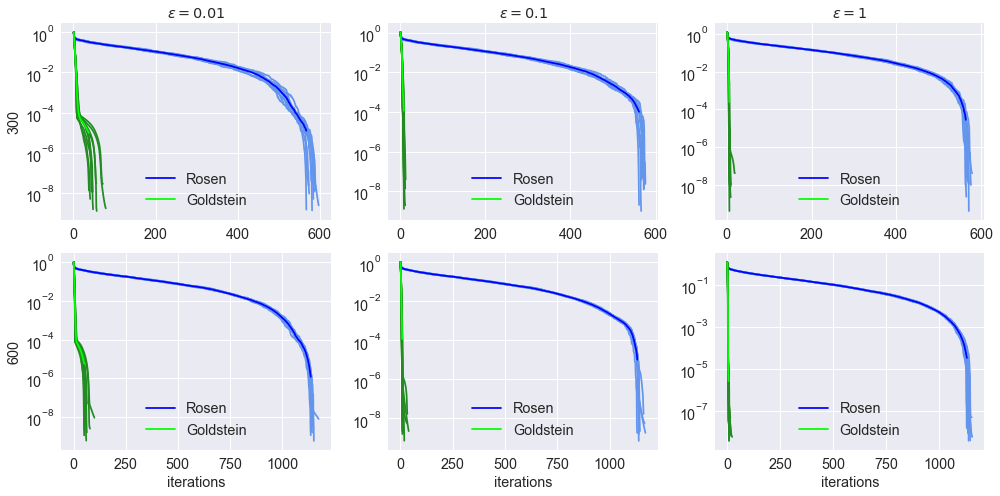

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(14,7))
sizes = [300,600]

eps_roots = ['NUOVI/RUNS/AIRF/'+i for i in epsilons]

for i,root in enumerate(eps_roots):
    for j,size in enumerate(sizes):
        ax = axs[j][i]
        values_rosen = load_runs(root, size, "ROS", nproblems=10)
        
        values_goldstein = load_runs(root, size, "GOLD", nproblems=10)
        
        
        best_values = load_external_solver_values(root, size)
        
        values_rosen = [relative_gap(i, opt) for i, opt in zip(values_rosen, best_values)]
        values_goldstein = [relative_gap(i, opt) for i, opt in zip(values_goldstein, best_values)]
        
        
        plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
        plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
        
        ax.set_yscale("log")
        

for ax, size in zip(axs[:,0], sizes):
    ax.set_ylabel(str(size))
    

for ax, eps in zip(axs[0], [0.01, 0.1, 1]):
    ax.set_title(f"$\epsilon = {eps}$")

for ax in axs[1]:
    ax.set_xlabel("iterations")

plt.tight_layout()

# CALIFORNIA - $\epsilon$

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(14,7))
sizes = [300,600]

california_eps = ['RUNS/CAL/'+i for i in epsilons]
for i,root in enumerate(california_eps):
    for j,size in enumerate(sizes):
        ax = axs[j][i]
        values_rosen = load_problems(str(size), alg="rosen", maindir=root)
        values_goldstein =  load_problems(str(size), alg="goldstein", maindir=root)
        
        _, datas, root_ = root.split("/")
        best_values = get_best_values(dataset=datas, size=size, params=root_)   
        values_rosen = [transform_values(i, opt) for i, opt in zip(values_rosen, best_values)]
        values_goldstein = [transform_values(i, opt) for i, opt in zip(values_goldstein, best_values)]
        
        plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
        plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
        #ax.set_title(str(size), fontdict={'fontsize': 15})
        #ax.set_xscale("log") # use logaritmic scale for x
        ax.set_yscale("log")
        

for ax, size in zip(axs[:,0], sizes):
    ax.set_ylabel(str(size))
    

for ax, eps in zip(axs[0], [0.01, 0.1, 1]):
    ax.set_title(f"$\epsilon = {eps}$")

for ax in axs[1]:
    ax.set_xlabel("iterations")



m, M = axs[0][0].get_ylim()
#for ax in axs[0]:
#    ax.vlines(30, m, M,colors='r', linestyles='dashed')
m, M = axs[1][0].get_ylim()
#for ax in axs[1]:
#    ax.vlines(30, m, M,colors='r', linestyles='dashed')

plt.tight_layout()

# GRAFICI SEPARATI

In [ ]:
def load_problems_from_path(size, measure='val', start_range=0,nproblems=20, path=""):
    """extract one column from all the csv of that size and algorithm"""
    path = path
    problem_values = []
    for i in range(start_range, nproblems):
        filepath = path + f"/{i}.csv"
        problem_values.append(pd.read_csv(filepath, usecols=[measure]).to_numpy())
    return problem_values

In [ ]:
ALG = "GOLD"
fig, axs = plt.subplots(ncols=3, figsize=(16,5))
sizes = [600]
data = [f"RUNS/{i}/C1EPS01/600/{ALG}" for i in rootdataset]
for i,root in enumerate(data):
    for j,size in enumerate(sizes):
        ax = axs[i]
        
        r, ds, root_, s_, alg = root.split('/')
        best_values = get_best_values(dataset=ds, size=size, params=root_)
        
        values =  load_problems_from_path(str(size), path=root)
        values_transformed = [transform_values(i, opt) for i, opt in zip(values, best_values)]
        
        plot_multiple_functions(values_transformed, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
        ax.set_yscale("log")
        
for ax in axs:
    ax.set_xlabel("iterations")

for (ax, title) in zip(axs, rootdataset):
    ax.set_title(title)

plt.tight_layout()

In [ ]:
ALG = "ROS"
fig, axs = plt.subplots(ncols=3, figsize=(16,5))
sizes = [600]
data = [f"RUNS/{i}/C1EPS01/600/{ALG}" for i in rootdataset]
for i,root in enumerate(data):
    for j,size in enumerate(sizes):
        ax = axs[i]
        r, ds, root_, s_, alg = root.split('/')
        best_values = get_best_values(dataset=ds, size=size, params=root_)
        
        values =  load_problems_from_path(str(size), path=root)
        values_transformed = [transform_values(i, opt) for i, opt in zip(values, best_values)]
        plot_multiple_functions(values_transformed, plot_avg=True, ax=ax,label="Rosen")
        ax.set_yscale("log")
        
for ax in axs:
    ax.set_xlabel("iterations")

for (ax, title) in zip(axs, rootdataset):
    ax.set_title(title)

plt.tight_layout()

# CONVERGENCE RESULTS

In [ ]:
# TODO generare convergenza con valori ottimi presi dal file

In [ ]:
epsilons

In [ ]:
upperbounds

In [ ]:
convergence_ml_gold = compute_convergence("C1EPS01", 600, "ML", "g")
convergence_ml_ros = compute_convergence("C1EPS01", 600, "ML", "r")

convergence_airf_gold = compute_convergence("C1EPS01", 600, "AIRF", "g")
convergence_airf_ros = compute_convergence("C1EPS01", 600, "AIRF", "r")

convergence_cal_gold = compute_convergence("C1EPS01", 600, "CAL", "g")
convergence_cal_ros = compute_convergence("C1EPS01", 600, "CAL", "r")

In [ ]:
size = 600
root = 'RUNS/AIRF/C1EPS01'
_, dataset, root_ = root.split('/')
best_values = get_best_values(dataset, size, root_)
values =  load_problems(str(size), alg="goldstein", maindir=root, nproblems=20)
#conv = convergence(values, optimal_values)
values_goldstein = [transform_values(i, opt) for i, opt in zip(values, best_values)]

In [ ]:
size=600
root = "RUNS/CAL/C1EPS01"
_, dataset, root_ = root.split('/')
best_values = get_best_values(dataset, size, root_)
values =  load_problems(str(size), alg="rosen", maindir=root, nproblems=20)
values_rosen = [transform_values(i, opt) for i, opt in zip(values, best_values)]

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex="col", figsize=(15,7))
conv = convergence_airf_gold
####
idx = 13
axs[0][0].plot(range(len(values_goldstein[idx])), values_goldstein[idx])
axs[0][0].set_yscale("log")
axs[1][0].plot(range(len(conv[idx])), conv[idx])
####
idx = 18
axs[0][1].plot(range(len(values_goldstein[idx])), values_goldstein[idx])
axs[0][1].set_yscale("log")
axs[1][1].plot(range(len(conv[idx])), conv[idx])
###
axs[1][0].set_xlabel("iterations")
axs[1][1].set_xlabel("iterations")

axs[0][0].set_ylabel("$G_i$")
axs[1][0].set_ylabel("$r_i$")

plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))
conv = convergence_cal_ros
idx = 3
axs[0].plot(range(len(values_rosen[idx])), values_rosen[idx])
axs[0].set_yscale("log")
axs[1].plot(range(len(conv[idx])), conv[idx])

axs[0].set_xlabel("iterations")
axs[1].set_xlabel("iterations")

axs[0].set_ylabel("$G_i$")
axs[1].set_ylabel("$r_i$")

plt.tight_layout()

# ALPHAS

In [ ]:
def transform_values_alpha(ll, opt):
    new_list = []
    for l  in ll:
        new_list.append((l - opt) / np.abs(opt))
    return new_list

In [ ]:
basedir = "./RUNS/{}/ALPHA"
nproblems = 5
alphas = [0.1, 0.5, 1, 2, 5]

## CALIFORNIA

In [ ]:
california_alphas_path = basedir.format("CAL")
# lista di liste di array
# prima lista = alphas
# seconda lista = runs
# array = singola run
calif_alpha_list = [load_alphas(california_alphas_path, str(a).replace(".", "")) for a in alphas]

In [ ]:
calif_alpha_list

In [ ]:
#calif_alphas = []
calif_alphas = list(zip(*calif_alpha_list))
calif_alphas = [list(l) for l in calif_alphas]
california_optimal_values = get_alphas_best_values("CAL", alphas)

In [ ]:
calif_transformed_values = transform_values_alpha(calif_alpha_list, california_optimal_values)

In [ ]:
for alpha in range(len(alphas)):
    # (run, alpha)
    plt.plot(calif_transformed_values[0][alpha], label=str(alphas[alpha]))
plt.gca().set_yscale("log")
plt.gca().set_xlim(0,50)
#plt.gca().set_ylim(1e-3,0)
plt.legend(title="alpha", title_fontsize=16)

In [ ]:
for i, a in enumerate(calif_alphas[0]):
    l = [transform_values()]
    plt.plot(a, label=str(alphas[i]))
    print(len(a))
plt.gca().set_xlim(0, 100)
plt.legend(title="alpha", title_fontsize=16)

In [ ]:
for i, a in enumerate(calif_alphas[1]):
    plt.plot(a, label=str(alphas[i]))
    
plt.gca().set_xlim(0, 100)
plt.legend(title="alpha", title_fontsize=16)

In [ ]:
for i, a in enumerate(calif_alphas[2]):
    plt.plot(a, label=str(alphas[i]))
    
plt.gca().set_xlim(0, 100)
plt.legend(title="alpha", title_fontsize=16)

In [ ]:
for i, a in enumerate(calif_alphas[3]):
    plt.plot(a, label=str(alphas[i]))
    
plt.gca().set_xlim(0, 100)
plt.legend(title="alpha", title_fontsize=16)

In [ ]:
for i, a in enumerate(calif_alphas[4]):
    plt.plot(a, label=str(alphas[i]))
    
plt.gca().set_xlim(0, 100)
plt.legend(title="alpha", title_fontsize=16)

## ML

In [ ]:
ml_alphas_path = basedir.format("ML")
ml_alphas_path

In [ ]:
ml_alphas_list = [load_alphas(ml_alphas_path, str(a).replace(".", "")) for a in alphas]
ml_alphas = list(zip(*ml_alphas_list))

In [ ]:
for i, a in enumerate(ml_alphas[0]):
    plt.plot(a, label=str(alphas[i]))
    print(len(a))
plt.gca().set_xlim(0, 100)
plt.legend(title="alpha", title_fontsize=16)

In [ ]:
for i, a in enumerate(ml_alphas[1]):
    plt.plot(a, label=str(alphas[i]))
    
plt.gca().set_xlim(0, 100)
plt.legend(title="alpha", title_fontsize=16)

In [ ]:
for i, a in enumerate(ml_alphas[2]):
    plt.plot(a, label=str(alphas[i]))
    
plt.gca().set_xlim(0, 100)
plt.legend(title="alpha", title_fontsize=16)

In [ ]:
for i, a in enumerate(ml_alphas[3]):
    plt.plot(a, label=str(alphas[i]))
    
plt.gca().set_xlim(0, 100)
plt.legend(title="alpha", title_fontsize=16)

In [ ]:
for i, a in enumerate(ml_alphas[4]):
    plt.plot(a, label=str(alphas[i]))
    
plt.gca().set_xlim(0, 100)
plt.legend(title="alpha", title_fontsize=16)

## AIRFOIL

In [ ]:
airf_alphas_path = basedir.format("AIRF")

In [ ]:
airf_alpha_list = [load_alphas(airf_alphas_path, str(a).replace(".", "")) for a in alphas]
airf_alphas = list(zip(*calif_alpha_list))

In [ ]:
for i, a in enumerate(airf_alphas[0]):
    plt.plot(a, label=str(alphas[i]))
    print(len(a))
plt.gca().set_xlim(0, 100)
plt.legend(title="alpha", title_fontsize=16)

In [ ]:
for i, a in enumerate(airf_alphas[1]):
    plt.plot(a, label=str(alphas[i]))
    
plt.gca().set_xlim(0, 100)
plt.legend(title="alpha", title_fontsize=16)

In [ ]:
for i, a in enumerate(airf_alphas[2]):
    plt.plot(a, label=str(alphas[i]))
    
plt.gca().set_xlim(0, 100)
plt.legend(title="alpha", title_fontsize=16)

In [ ]:
for i, a in enumerate(airf_alphas[3]):
    plt.plot(a, label=str(alphas[i]))
    
plt.gca().set_xlim(0, 100)
plt.legend(title="alpha", title_fontsize=16)

In [ ]:
for i, a in enumerate(airf_alphas[4]):
    plt.plot(a, label=str(alphas[i]))
    
plt.gca().set_xlim(0, 100)
plt.legend(title="alpha", title_fontsize=16)